**Random Effects modelling (frequentist) and Hierarchical modelling (Bayesian) on Grunfeld data.**

In [1]:
import warnings
import pandas as pd
import numpy as np
import pymc3 as pm
import theano
import statsmodels.api as sm
from linearmodels import RandomEffects

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
warnings.filterwarnings('ignore')

In [3]:
SEED = 14201

# Load data

In [4]:
df = sm.datasets.get_rdataset('Grunfeld', 'plm').data

In [5]:
df['year'] = pd.to_datetime(df['year'], format="%Y")
df = df.set_index(['firm', 'year'])

In [6]:
df.head()

inv   value  capital
firm year                              
1    1935-01-01  317.6  3078.5      2.8
     1936-01-01  391.8  4661.7     52.6
     1937-01-01  410.6  5387.1    156.9
     1938-01-01  257.7  2792.2    209.2
     1939-01-01  330.8  4313.2    203.4

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 200 entries, (1, Timestamp('1935-01-01 00:00:00')) to (10, Timestamp('1954-01-01 00:00:00'))
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   inv      200 non-null    float64
 1   value    200 non-null    float64
 2   capital  200 non-null    float64
dtypes: float64(3)
memory usage: 5.4 KB


https://docs.pymc.io/notebooks/GLM-hierarchical.html

# Random Effects model

Frequentist model.

In [8]:
y_list = ['inv']
X_list = ['value', 'capital']

In [9]:
%%time
model_re = RandomEffects(df[y_list], df[X_list])
results_re = model_re.fit(cov_type='clustered')

CPU times: user 302 ms, sys: 1.91 ms, total: 304 ms
Wall time: 102 ms


In [10]:
results_re.summary

Dep. Variable:,inv,R-squared:,0.7734
Estimator:,RandomEffects,R-squared (Between):,0.8413
No. Observations:,200,R-squared (Within):,0.7659
Date:,"Sat, Mar 07 2020",R-squared (Overall):,0.8289
Time:,18:06:42,Log-likelihood,-1078.4
Cov. Estimator:,Clustered,,
,,F-statistic:,337.97
Entities:,10,P-value,0.0000
Avg Obs:,20.000,Distribution:,"F(2,198)"
Min Obs:,20.000,,
Max Obs:,20.000,F-statistic (robust):,36.643


In [11]:
results_re.estimated_effects.groupby('firm').mean()

,estimated_effects
firm,
1,-28.973621
2,100.941081
3,-186.647978
4,-18.708501
5,-94.867015
6,-16.636171
7,-54.897627
8,-44.298208
9,-71.318281


# Hierarchical model (Bayesian)

Similarity to random effects modelling.

## Centred model

In [12]:
def get_model(df):
    with pm.Model() as hierarchical_model:
        n_entities = df.index.get_level_values('firm').nunique()
        entities_list = df.index.get_level_values('firm').unique().tolist()
        entity_indices = {k:v for k,v in
                          zip(entities_list, list(range(n_entities)))}
        entities_ix_array = df.index.get_level_values('firm').map(entity_indices)
        
        # Hyper-priors
        mu_a = pm.Normal('mu_a', mu=0., sigma=10)
        mu_value = pm.Normal('mu_value', mu=0, sigma=10)
        mu_capital = pm.Normal('mu_capital', mu=0, sigma=10)
        sigma_a = pm.HalfNormal('sigma_a', 5)
        sigma_value = pm.HalfNormal('sigma_value', 5)
        sigma_capital = pm.HalfNormal('sigma_capital', 5)

        # Priors from hyper-priors
        alpha = pm.Normal('alpha', mu=mu_a,
                          sigma=sigma_a,
                          shape=n_entities)  # a_it
        b_value = pm.Normal('b_value', mu=mu_value,
                            sigma=sigma_value)
        b_capital = pm.Normal('b_capital', mu=mu_capital,
                              sigma=sigma_capital)
    
        # Model error
        eps = pm.HalfCauchy('eps', 5.)

        y_est = (alpha[entities_ix_array]
                 + b_value * df['value'].values
                 + b_capital * df['capital'].values)
    
        # Calc likelihood (vectorized)
        y_likelihood = pm.Normal('y_likelihood', mu=y_est,
                                 sigma=eps, observed=df['inv'].values)
    
    return hierarchical_model

In [13]:
def do_model_inference(*, model, random_seed, draws=2000, tune=2000, target_accept=0.9):
    with model:
        trace = pm.sample(draws, tune=tune, random_seed=random_seed,
                          step=pm.NUTS(target_accept=target_accept))
    return trace

In [14]:
hierarchical_model = get_model(df)

In [15]:
%%time
trace = do_model_inference(model=hierarchical_model, random_seed=SEED,
                           draws=2000, tune=5000)

Multiprocess sampling (4 chains in 4 jobs)
NUTS: [eps, b_capital, b_value, alpha, sigma_capital, sigma_value, sigma_a, mu_capital, mu_value, mu_a]
Sampling 4 chains, 551 divergences: 100%|██████████| 28000/28000 [00:46<00:00, 598.94draws/s]
There were 152 divergences after tuning. Increase `target_accept` or reparameterize.
There were 111 divergences after tuning. Increase `target_accept` or reparameterize.
There were 126 divergences after tuning. Increase `target_accept` or reparameterize.
There were 161 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


CPU times: user 13.9 s, sys: 710 ms, total: 14.6 s
Wall time: 51.7 s


In [16]:
vars_list = ['mu_a', 'mu_value', 'mu_capital',
             'sigma_a', 'sigma_value', 'sigma_capital', 'eps']

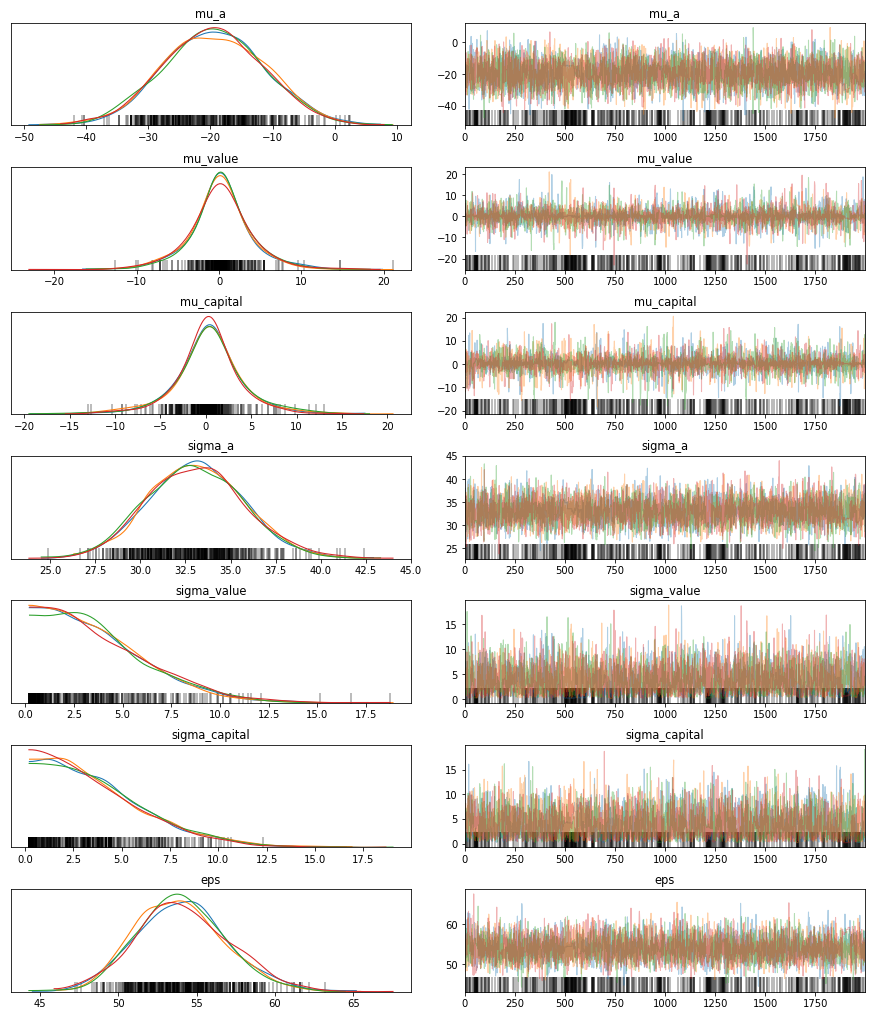

In [17]:
pm.traceplot(trace, var_names=vars_list)
plt.show()

For good estimation of the free variables across the chains, a few thousand tuning steps (e.g. 5000) was needed for this model.

In [18]:
pm.summary(trace, var_names=vars_list)

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
mu_a,-19.566,8.074,-34.909,-4.824,0.132,0.094,3756.0,3653.0,3749.0,4368.0,1.0
mu_value,0.119,3.815,-7.841,7.498,0.061,0.051,3862.0,2764.0,4112.0,3698.0,1.0
mu_capital,0.282,3.784,-6.829,8.761,0.065,0.059,3379.0,2080.0,3937.0,2824.0,1.0
sigma_a,33.074,2.633,28.067,37.913,0.041,0.029,4114.0,4114.0,4107.0,5028.0,1.0
sigma_value,3.823,2.734,0.196,8.689,0.058,0.041,2206.0,2206.0,964.0,347.0,1.0
sigma_capital,3.806,2.742,0.203,8.821,0.052,0.037,2804.0,2804.0,1716.0,1009.0,1.0
eps,54.008,2.868,48.811,59.422,0.044,0.031,4193.0,4159.0,4269.0,5072.0,1.0


In [19]:
pm.summary(trace, var_names=['alpha'])

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
alpha[0],-17.814,27.026,-67.732,32.805,0.521,0.368,2695.0,2695.0,2698.0,4168.0,1.0
alpha[1],108.670,16.404,80.052,141.911,0.290,0.207,3194.0,3153.0,3203.0,3729.0,1.0
alpha[2],-187.211,16.558,-216.714,-154.104,0.297,0.210,3098.0,3098.0,3101.0,3144.0,1.0
alpha[3],-19.076,12.058,-41.396,3.630,0.201,0.142,3584.0,3584.0,3586.0,3049.0,1.0
alpha[4],-93.903,13.797,-119.940,-67.914,0.244,0.179,3185.0,2978.0,3234.0,2396.0,1.0
alpha[5],-17.467,11.684,-38.823,5.106,0.166,0.124,4947.0,4466.0,4946.0,3274.0,1.0
alpha[6],-54.770,12.400,-79.680,-32.393,0.181,0.129,4707.0,4594.0,4712.0,5278.0,1.0
alpha[7],-46.095,11.953,-68.362,-23.878,0.186,0.132,4118.0,4087.0,4114.0,4467.0,1.0
alpha[8],-71.633,12.186,-93.807,-48.464,0.174,0.124,4923.0,4845.0,4903.0,4865.0,1.0
alpha[9],-7.495,11.079,-28.306,13.147,0.145,0.142,5866.0,3062.0,5836.0,4178.0,1.0


Estimates in this case appear similar to the random effects model, e.g.:
- `alpha`: firm-level effects
- Regressor coefficients, e.g. $\beta_{value} \approx\ 0.1$ and $\beta_{capital} \approx\ 0.3$

## Non-centered model

Centred model appears a good model from the traceplot, but perhaps the estimation could be better for some of the variables via a non-centred model.

In [20]:
def get_non_centred_model(df):
    with pm.Model() as hierarchical_model_non_centred:
        n_entities = df.index.get_level_values('firm').nunique()
        entities_list = df.index.get_level_values('firm').unique().tolist()
        entity_indices = {k:v for k,v in
                          zip(entities_list, list(range(n_entities)))}
        entities_ix_array = df.index.get_level_values('firm').map(entity_indices)
        
        # Hyper-priors
        mu_a = pm.Normal('mu_a', mu=0., sigma=10)
        mu_value = pm.Normal('mu_value', mu=0, sigma=10)
        mu_capital = pm.Normal('mu_capital', mu=0, sigma=10)
        sigma_a = pm.HalfNormal('sigma_a', 5)
        sigma_value = pm.HalfNormal('sigma_value', 5)
        sigma_capital = pm.HalfNormal('sigma_capital', 5)

        # Priors from hyper-priors
        alpha_offset = pm.Normal('alpha_offset', mu=0, sigma=1,
                                 shape=n_entities)  # a_it
        alpha = pm.Deterministic('alpha', mu_a + alpha_offset * sigma_a)
        
        b_value_offset = pm.Normal('b_value_offset', mu=0, sigma=1)
        b_value = pm.Deterministic('b_value', mu_value + b_value_offset * sigma_value)
        
        b_capital_offset = pm.Normal('b_capital_offset', mu=0, sigma=1)
        b_capital = pm.Deterministic('b_capital', mu_capital + b_capital_offset * sigma_capital)
        
        # Model error
        eps = pm.HalfCauchy('eps', 5.)

        y_est = (alpha[entities_ix_array]
                 + b_value * df['value'].values
                 + b_capital * df['capital'].values)
    
        # Calc likelihood (vectorized)
        y_likelihood = pm.Normal('y_likelihood', mu=y_est,
                                 sigma=eps, observed=df['inv'].values)
    
    return hierarchical_model_non_centred

In [21]:
hierarchical_model_non_centred = get_non_centred_model(df)

In [22]:
%%time
trace_nc = do_model_inference(model=hierarchical_model_non_centred, random_seed=SEED,
                              draws=2000, tune=5000)

Multiprocess sampling (4 chains in 4 jobs)
NUTS: [eps, b_capital_offset, b_value_offset, alpha_offset, sigma_capital, sigma_value, sigma_a, mu_capital, mu_value, mu_a]
Sampling 4 chains, 35 divergences: 100%|██████████| 28000/28000 [25:37<00:00, 18.21draws/s]
There were 17 divergences after tuning. Increase `target_accept` or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
There were 16 divergences after tuning. Increase `target_accept` or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The rhat statistic is larger than 1.2 for some parameters

CPU times: user 26.5 s, sys: 2.89 s, total: 29.4 s
Wall time: 25min 42s


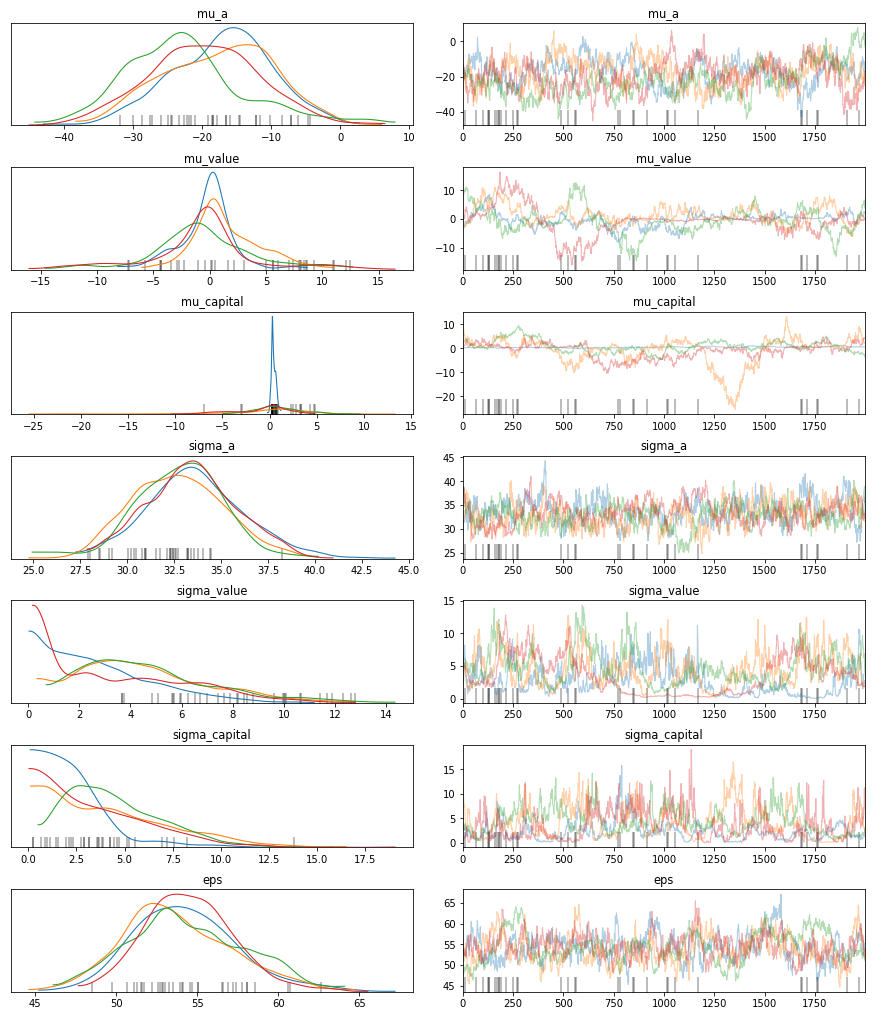

In [23]:
pm.traceplot(trace_nc, var_names=vars_list)
plt.show()

From the plots, the non-centred model appears worse.

In [24]:
pm.summary(trace_nc, var_names=vars_list)

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
mu_a,-19.320,8.295,-34.976,-4.481,1.607,1.149,27.0,27.0,27.0,236.0,1.11
mu_value,-0.043,3.972,-6.875,10.403,0.542,0.413,54.0,47.0,55.0,62.0,1.08
mu_capital,-0.223,3.664,-7.113,5.610,0.547,0.389,45.0,45.0,46.0,53.0,1.32
sigma_a,33.125,2.470,28.382,37.616,0.219,0.155,127.0,127.0,127.0,286.0,1.03
sigma_value,3.853,2.647,0.037,8.472,0.436,0.311,37.0,37.0,27.0,86.0,1.12
sigma_capital,3.617,2.737,0.094,8.702,0.317,0.225,74.0,74.0,76.0,153.0,1.07
eps,54.202,3.266,48.336,60.658,0.282,0.200,135.0,135.0,136.0,264.0,1.01


In [25]:
pm.summary(trace_nc, var_names=['alpha'])

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
alpha[0],-23.180,25.652,-71.630,22.599,3.207,2.278,64.0,64.0,67.0,219.0,1.08
alpha[1],106.089,15.787,76.090,135.579,1.533,1.142,106.0,96.0,108.0,537.0,1.04
alpha[2],-188.490,16.582,-218.460,-157.512,2.056,1.498,65.0,62.0,66.0,271.0,1.07
alpha[3],-20.491,11.848,-41.616,3.094,0.875,0.625,184.0,180.0,184.0,367.0,1.03
alpha[4],-94.638,13.863,-119.592,-67.874,0.792,0.561,306.0,306.0,310.0,557.0,1.01
alpha[5],-17.976,12.072,-41.191,4.385,0.976,0.692,153.0,153.0,157.0,255.0,1.03
alpha[6],-54.729,12.788,-79.502,-30.416,0.984,0.725,169.0,156.0,173.0,295.0,1.05
alpha[7],-48.154,11.674,-69.438,-25.533,1.038,0.755,126.0,120.0,126.0,263.0,1.04
alpha[8],-70.718,12.437,-93.271,-46.665,0.806,0.571,238.0,238.0,239.0,645.0,1.01
alpha[9],-7.493,10.999,-28.022,13.354,0.637,0.451,298.0,298.0,300.0,507.0,1.03


In this case, the non-centred model seems like a worse model, from the traceplot.  More tuning did not make the model do better in terms of convergence.

# Resources

- [Why hierarchical models are awesome, tricky, and Bayesian](https://twiecki.io/blog/2017/02/08/bayesian-hierchical-non-centered/)
- [GLM: Hierarchical Linear Regression](https://docs.pymc.io/notebooks/GLM-hierarchical.html)